In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time

In [2]:
# Position
x0 = 0
xf = np.array([-15, 15])
xobs = [[-14, -13], [-6, -5.5], [4, 5.5], [10, 11.5]]
prox = [2.5, 2.5] # [x, t]

In [3]:
# General RRT Settings
K = 1000
iter_max = 1
tMax = 20
vmax = 2

In [4]:
# Obstacle Setting
# [start, close, open]
obs1 = [0, 5, 2]
obs2 = [0, 4, 1]
obs3 = [0, 3, 3.5]
obs4 = [0, 4, 3]
obs_vec = [obs1, obs2, obs3, obs4]

In [5]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

In [6]:
def distance(a, b):
    return b - a

In [7]:
def random_sample():
    trand = rn.uniform(1e-1, tMax)
    """sign = 0
    if rn.random() < 0.5:
        sign = 1
    else:
        sign = -1
    xrand = sign*rn.uniform(0, trand*vmax+x0)"""
    check = rn.uniform(0, 1)
    
    if check >= 0 and check < 0.9:
        xrand = rn.uniform(trand*(-vmax)+x0, trand*vmax+x0)
    elif check >= 0.9:
        xrand = xf[1]
        trand = xf[1]
    qrand = [xrand, trand]
    return qrand

In [8]:
def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

In [9]:
def check_route(qclosest, qnew):
    route_check = []
    div = 10000
    tspace = np.linspace(0, 1, div)
    for t in tspace:
        xmove = (qnew[0]-qclosest[0])*t
        tmove = (qnew[1]-qclosest[1])*t
        qcheck = [qclosest[0]+xmove, qclosest[1]+tmove]
        check_vec = validate(qcheck)

        if np.sum(check_vec) == 0:
            route_check.append(0)
        else:
            return False

    if np.sum(route_check) == 0:
        return True # No Path Collision
    else:
        return False # Path Collision

In [10]:
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    if dx == 0:
        return True
    else:
        if dt > 0 and np.abs(dx/dt) <= vmax:
            return True
        else:
            return False

In [11]:
def find_neighbor(qrand, V):
    # Find neighbor
    dist_vec = []
    for i in range(len(V)):
        if reachable(V[i], qrand):
            dist_vec.append(distance(V[i][0], qrand[0]))
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [12]:
def extend(qclosest, q1):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    norm = np.sqrt(dx**2 + dt**2)
    dxnorm = dx/norm*vmax
    dtnorm = dt/norm*vmax
    #qnew = [qclosest[0]+dxnorm*vmax, qclosest[1]+dtnorm*vmax]
    qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [13]:
def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [14]:
# Standard RRT
time_vec = []
iter = 0
K = 1000

while iter < iter_max:
    start = time.time()
    k = 0
    V_RRT = []
    V_RRT.append([x0, 0])
    V_RRT_raw = []
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []
    sanity = []
    path_RRT = None
    #while k < K:
    while 1:
        print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRT)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0 and check_route(qclosest, qnew):
                    break

        # Add V, E
        k += 1
        #print('qrand: ', qrand)
        #print('qnew: ', qnew)
        V_RRT.append(qnew)
        sanity.append(qrand)
        V_RRT_raw.append(qrand)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[1])

        # Check continue
        dist_check = []
        for i in range(len(xf)):
            if np.abs(distance(xf[i], qnew[0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
        if np.sum(dist_check) > 0:
            end_cond = dist_check.index(1)
            dist_to_fin = distance(xf[i], qnew[0])
            qfin = [xf[end_cond], qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            break
    path_RRT = find_path(xf, E_RRT)
    end = time.time()
    
    time_vec.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec)/len(time_vec))

k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
k:  82
k:  83
k:  84
k:  85
k:  86
k:  87
k:  88
k:  89
k:  90
k:  91
k:  92
k:  93
k:  94
k:  95
k:  96
k:  97
k:  98
k:  99
k:  100
k:  101
k:  102
k:  103
k:  104
k:  105
k:  106
k:  107
k:  108
k:  109
k:  110
k:  111
k:  112
k:  113
k:  114
k:  115
k:  116
k:  117
k:  118
k:  119
k:  120
k:  121
k:  122
k:  123
k:  124
k:  125
k:  126
k:  127
k:  128
k:  129
k:  130
k:  131
k:  132
k:  133
k:  134
k:  135
k:  136
k:  137
k:  13

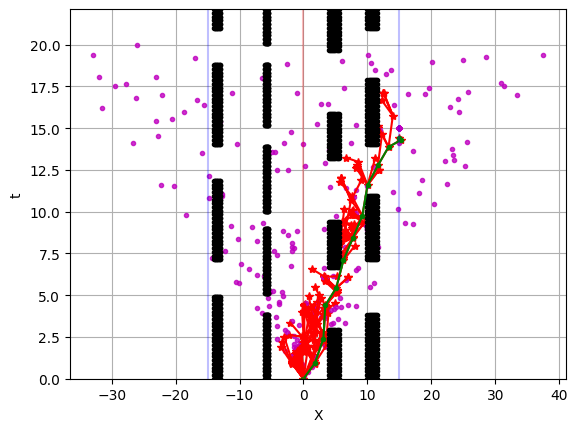

In [15]:
fig = plt.figure()
ax = fig.subplots()
# RRT
for rrtv in V_RRT:
    plt.plot(rrtv[0], rrtv[1], 'r*')
for rrtvrnd in V_RRT_raw:
    plt.plot(rrtvrnd[0], rrtvrnd[1], 'm.', alpha=0.8)
for rrte in E_RRT:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, max(T_RRT)+5, 100)
for xobsi in range(len(xobs)):
    xobs_this = xobs[xobsi]
    xspace = np.linspace(xobs_this[0], xobs_this[1], 10)
    for xi in xspace:
        for ti in tspace:
            if not obstacle_check(ti, obs_vec[xobsi]):
                plt.plot(xi, ti, 'k.')#, alpha=0.25)

# Path
for pathi in path_RRT:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRT)-1):
    plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# Initial/Final
plt.plot([x0, x0], [0, max(T_RRT)+5], 'r-', alpha=0.25)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, max(T_RRT)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf[1]+1)
plt.ylim(0, max(T_RRT)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

In [16]:
# Save files
save = False

if save:
    import pickle
            
    RRT = {}
    RRT['V'] = V_RRT
    RRT['E'] = E_RRT
    RRT['T'] = T_RRT

    with open("RRT", "wb") as fp:   #Pickling
        pickle.dump(RRT, fp)

In [17]:
def neighbors(prox, q0, V_RRTstar):
    output = []
    for v in V_RRTstar:
        if 0 <= q0[0]-v[0] <= prox[0] and 0 <= q0[1]-v[1] <= prox[1] and reachable(v, q0):
            output.append(v)
    return output

In [18]:
# Stardard RRT*
time_vec_star = []
iter = 0

while iter < iter_max:
    start = time.time()
    k = 0
    V_RRTstar = []
    V_RRTstar.append([x0, 0])
    T_RRTstar = []
    T_RRTstar.append(0)
    E_RRTstar = []
    while k < K:
        print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRTstar)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew):
                        break

        # Add V, E
        k += 1
        V_RRTstar.append(qnew)
        E_RRTstar.append([qclosest, qnew])
        T_RRTstar.append(qnew[1])

        # Rewiring
        if k > 1:
            qmin = qclosest
            cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
            neighbor_vector = neighbors(prox, qnew, V_RRTstar)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                        cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                        qmin = v
                E_RRTstar.append([qnew, qmin])

        # Check continue
        dist_check = []
        for i in range(len(xf)):
            if np.abs(distance(xf[i], V_RRTstar[-1][0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
        if np.sum(dist_check) > 0 or k > K:
            end_cond = dist_check.index(1)
            dist_to_fin = distance(xf[i], qnew[0])
            qfin = [xf[end_cond], qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRTstar.append(qfin)
            E_RRTstar.append([qnew, qfin])
            break
    path_RRTstar = find_path(xf, E_RRTstar)
    end = time.time()
    
    time_vec_star.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_star)/len(time_vec_star))

k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
Average Computation Time (sec):  2.4450266361236572


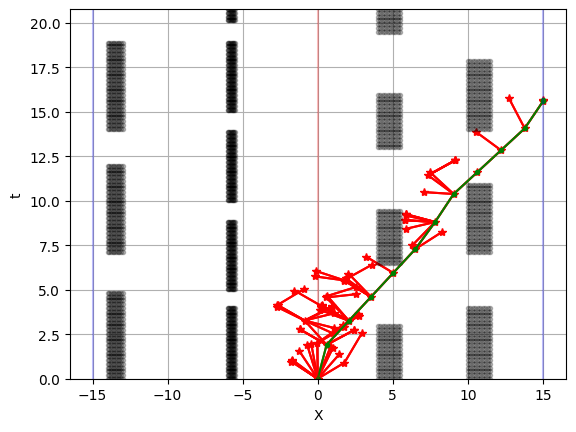

In [19]:
fig = plt.figure()
ax = fig.subplots()
# RRTstar
for rrtv in V_RRTstar:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrte in E_RRTstar:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, max(T_RRTstar)+5, 100)
for xobsi in range(len(xobs)):
    xobs_this = xobs[xobsi]
    xspace = np.linspace(xobs_this[0], xobs_this[1], 10)
    for xi in xspace:
        for ti in tspace:
            if not obstacle_check(ti, obs_vec[xobsi]):
                plt.plot(xi, ti, 'k.', alpha=0.25)

# Path
for pathi in path_RRTstar:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRTstar)-1):
    plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')


# Initial/Final
plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf[1]+1)
plt.ylim(0, max(T_RRTstar)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

In [20]:
adfasdfasf

NameError: name 'adfasdfasf' is not defined

In [ ]:
save = False

if save:
    import pickle
        
    RRTstar_data = {}
    RRTstar_data['V'] = V_RRTstar
    RRTstar_data['E'] = E_RRTstar
    RRTstar_data['T'] = T_RRTstar

    with open("RRTstar", "wb") as fp:   #Pickling
        pickle.dump(RRTstar_data, fp)
    
    """with open("RRT", "rb") as fp:   # Unpickling
    b = pickle.load(fp)"""

In [21]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import descartes

In [22]:
def validate_test(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], xobs[i], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])
    

In [201]:
def reachable_RRTC(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    
    if dx == 0:
        return True
    else:
        if forward and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        elif not forward and np.abs(dx/dt) <= vmax and dt < 0:
            return True
        return False

In [264]:
def random_sample_RRTC(tf, n, k):
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal and n == 1:
        # IF not, sample goal
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf[1]
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    elif not sample_goal or n >= 1:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf[1], tf]
        point3 = [-vmax/2*(tf - 1/vmax*(xf[1]+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf[1]+x0)))+x0/vmax]
        point4 = [vmax/2*(tf + 1/vmax*(xf[1]+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf[1]+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    return [xrand, trand]

In [238]:
def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(distance(V[i][0], qrand[0]))

    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [186]:
def check_route_test(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [122]:
def find_path_test(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec
            

In [265]:
# Standard ST-RRT-Connect
time_vec_RRTC = []
iter = 0
tf = 15
K = 1000
while iter < iter_max:
    start = time.time()
    t_test = []
    V_RRTConnect = {}
    E_RRTConnect = {}
    kk = 0
    while 1:
        tmax = tf
        print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf[1], tf])
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while k < K:
            t_check = []
            print('k: ', k)
            while 1:
                # Sample
                sample_start = time.time()
                qrand = random_sample_RRTC(tf, 1, k)
                # print('sample time: ', time.time()-sample_start)
                t_check.append(time.time()-sample_start)

                neighbor_start = time.time()
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                # print('neighbor check time: ', time.time()-neighbor_start)
                t_check.append(time.time()-neighbor_start)
                
                if qclosest is not None:
                    extend_start = time.time()
                    qnew = extend(qclosest, qrand)
                    print('extend time: ', time.time()-extend_start)
                    t_check.append(time.time()-extend_start)
                        
                    # Validate
                    validate_start = time.time()
                    check_vec = validate(qnew)
                    print('validation time: ', time.time()-validate_start)
                    t_check.append(time.time()-validate_start)
                    if np.sum(check_vec) == 0:
                        check_route_start = time.time()
                        kek = check_route_test(qclosest, qnew, tf)
                        # print('route_check: ', time.time()-check_route_start)
                        t_check.append(time.time()-check_route_start)
                        print('total: ', time.time()-sample_start)
                        if kek:
                            break
                
            # Add V, E
            add_start = time.time()
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)

            # Check continue
            path_check_start = time.time()
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5:
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5:
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            break
            # print('path_check: ', time.time()-path_check_start)
            t_check.append(time.time()-path_check_start)
            # print('total from sample: ', time.time()-sample_start)
            t_test.append(time.time()-sample_start)
            k += 1

            if path_check:
                print('Path Found')
                path_start = time.time()
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha_start = time.time()
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                print('Path a: ', time.time()-patha_start)
                pathb_start = time.time()
                pathb = find_path_test([xf[1], tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                print('Path b: ', time.time()-pathb_start)
                final_path = list(reversed(patha)) + pathb
                print('path compute: ', time.time()-path_start)
                break
        V_RRTConnect[str(kk)] = [V_RRTCa, V_RRTCb]
        E_RRTConnect[str(kk)] = [E_RRTCa, E_RRTCb]

        print('Path_check: ', path_check)
        if tf >= 40 or path_check:
            print('end')
            break
        tf += 5
        kk += 1

    end = time.time()
    print('final time: ', end-start)
    
    time_vec_RRTC.append(end-start)
    iter += 1


print('Average Computation Time (sec): ', sum(time_vec_RRTC)/len(time_vec_RRTC))

tf:  15
k:  0
extend time:  6.9141387939453125e-06
validation time:  4.5299530029296875e-06
total:  0.0018014907836914062
k:  1
extend time:  6.4373016357421875e-06
validation time:  4.76837158203125e-06
total:  0.0007307529449462891
k:  2
extend time:  3.5762786865234375e-06
validation time:  2.384185791015625e-06
total:  0.0005574226379394531
k:  3
extend time:  3.814697265625e-06
validation time:  2.1457672119140625e-06
total:  0.0005502700805664062
k:  4
extend time:  2.86102294921875e-06
validation time:  2.1457672119140625e-06
total:  0.0005328655242919922
k:  5
extend time:  5.0067901611328125e-06
validation time:  2.86102294921875e-06
total:  0.0006082057952880859
k:  6
extend time:  2.86102294921875e-06
validation time:  1.6689300537109375e-06
total:  0.0005109310150146484
k:  7
extend time:  3.5762786865234375e-06
validation time:  2.384185791015625e-06
total:  0.0005500316619873047
k:  8
extend time:  1.0013580322265625e-05
validation time:  2.1457672119140625e-06
total:  0.

In [275]:
# Standard ST-RRT-Connect // Bulk
time_vec_RRTC = []
iter = 0
tf = 15
K = 1000
while iter < iter_max:
    start = time.time()
    t_test = []
    V_RRTConnect = {}
    E_RRTConnect = {}
    kk = 0
    while 1:
        tmax = tf
        print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf[1], tf])
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        qrand_list = random_sample_RRTC(tf, K, k)

        while k < K:
            t_check = []
            print('k: ', k)
            # Sample
            sample_start = time.time()
            qrand = qrand_list[k]
            # print('sample time: ', time.time()-sample_start)
            t_check.append(time.time()-sample_start)

            neighbor_start = time.time()
            if np.mod(k, 2) == 0:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
            else:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
            # print('neighbor check time: ', time.time()-neighbor_start)
            t_check.append(time.time()-neighbor_start)
            
            if qclosest is not None:
                extend_start = time.time()
                qnew = extend(qclosest, qrand)
                print('extend time: ', time.time()-extend_start)
                t_check.append(time.time()-extend_start)
                    
                # Validate
                validate_start = time.time()
                check_vec = validate(qnew)
                print('validation time: ', time.time()-validate_start)
                t_check.append(time.time()-validate_start)
                if np.sum(check_vec) == 0:
                    check_route_start = time.time()
                    kek = check_route_test(qclosest, qnew, tf)
                    # print('route_check: ', time.time()-check_route_start)
                    t_check.append(time.time()-check_route_start)
                    print('total: ', time.time()-sample_start)
                    if kek:
                        break
                
            # Add V, E
            add_start = time.time()
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
            # print('Add time: ', time.time()-add_start)
            t_check.append(time.time()-add_start)

            # Check continue
            path_check_start = time.time()
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5:
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5:
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            break
            # print('path_check: ', time.time()-path_check_start)
            t_check.append(time.time()-path_check_start)
            # print('total from sample: ', time.time()-sample_start)
            t_test.append(time.time()-sample_start)
            k += 1

            if path_check:
                print('Path Found')
                path_start = time.time()
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha_start = time.time()
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                print('Path a: ', time.time()-patha_start)
                pathb_start = time.time()
                pathb = find_path_test([xf[1], tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                print('Path b: ', time.time()-pathb_start)
                final_path = list(reversed(patha)) + pathb
                print('path compute: ', time.time()-path_start)
                break
        V_RRTConnect[str(kk)] = [V_RRTCa, V_RRTCb]
        E_RRTConnect[str(kk)] = [E_RRTCa, E_RRTCb]

        print('Path_check: ', path_check)
        if tf >= 40 or path_check:
            print('end')
            break
        tf += 5
        kk += 1

    end = time.time()
    print('final time: ', end-start)
    
    time_vec_RRTC.append(end-start)
    iter += 1


print('Average Computation Time (sec): ', sum(time_vec_RRTC)/len(time_vec_RRTC))

tf:  15
k:  0
extend time:  7.62939453125e-06
validation time:  4.76837158203125e-06
total:  0.0005326271057128906
Path_check:  False
tf:  20
k:  0
extend time:  5.4836273193359375e-06
validation time:  3.5762786865234375e-06
total:  0.0004634857177734375
Path_check:  False
tf:  25
k:  0
extend time:  9.059906005859375e-06
validation time:  5.0067901611328125e-06
total:  0.0008704662322998047
Path_check:  False
tf:  30
k:  0
extend time:  6.198883056640625e-06
validation time:  4.5299530029296875e-06
total:  0.0007104873657226562
Path_check:  False
tf:  35
k:  0
extend time:  4.5299530029296875e-06
validation time:  3.337860107421875e-06
total:  0.0006725788116455078
Path_check:  False
tf:  40
k:  0
extend time:  3.814697265625e-06
validation time:  2.6226043701171875e-06
total:  0.0007052421569824219
Path_check:  False
end
final time:  0.06481075286865234
Average Computation Time (sec):  0.06481075286865234


0.287076473236084


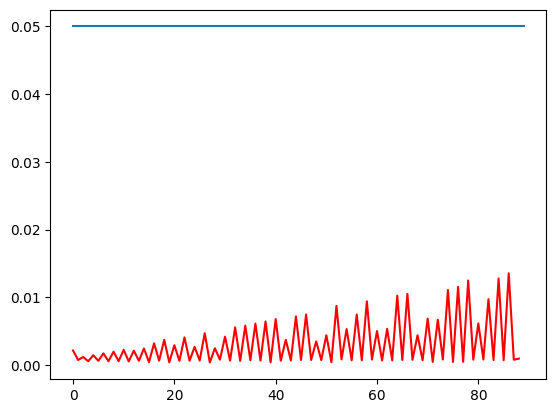

In [266]:
fig = plt.figure()
xvec = np.linspace(0, len(t_test)-1, len(t_test))
plt.plot(xvec, t_test, '-r')
plt.plot([0, len(xvec)], [0.05, 0.05])
print(np.sum(t_test))

3.7670135498046875e-05


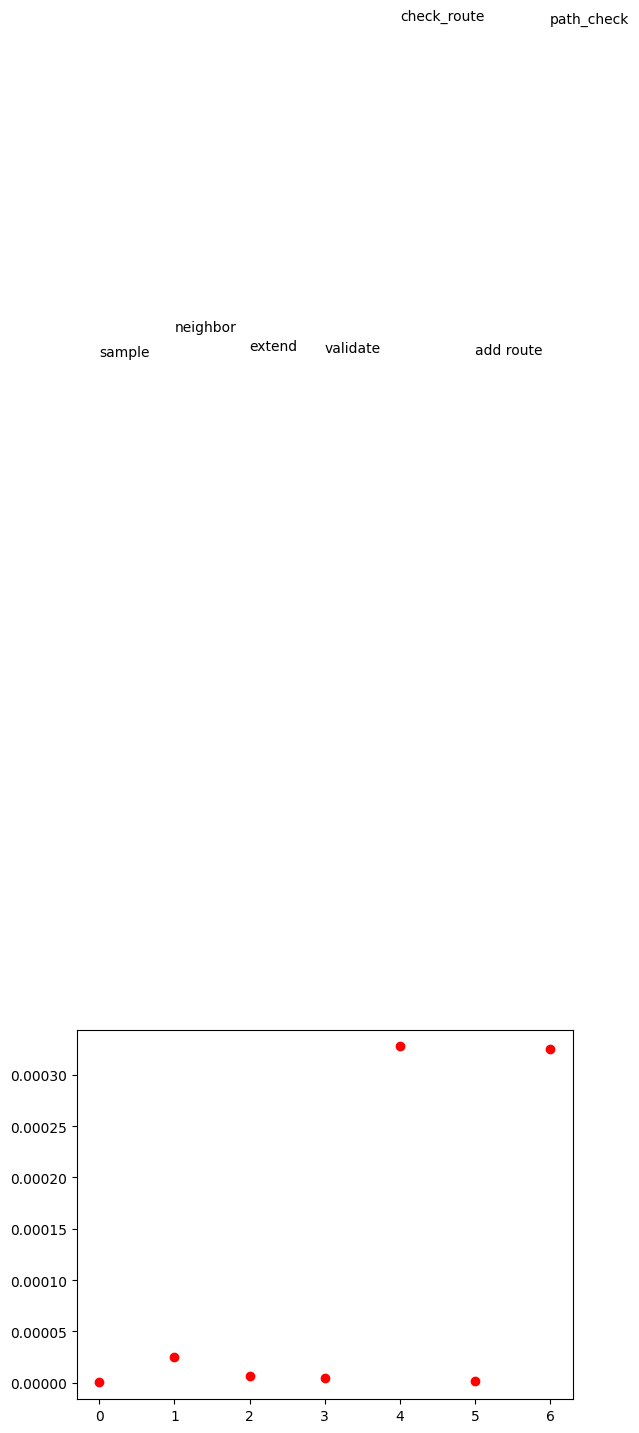

In [270]:
legend_vec = ['sample', 'neighbor', 'extend', 'validate', 'check_route', 'add route', 'path_check']
fig = plt.figure()
xvec = np.linspace(0, len(t_check)-1, len(t_check))
for i in range(len(xvec)):
    plt.plot(xvec[i], t_check[i], 'or')
    plt.text(xvec[i], t_check[i]+0.001, legend_vec[i])
print((sum(t_check[0:4])+t_check[5]))

Text(0, 0.5, 't')

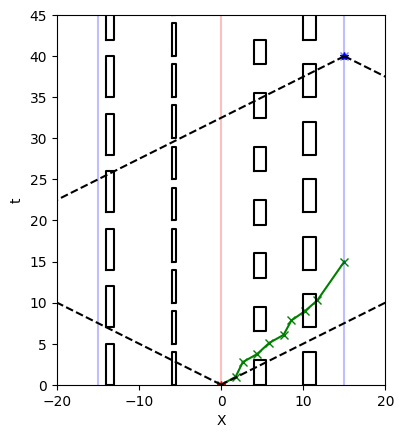

In [277]:
fig = plt.figure()
ax = fig.subplots()
# RRTConnect
for rrtv in V_RRTCa:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrtv in V_RRTCb:
   plt.plot(rrtv[0], rrtv[1], 'b*')
# for rrtvr in V_RRTCb_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'm.')
for rrte in E_RRTCa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)
for rrte in E_RRTCb:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-')#, alpha=0.25)
if final_path is not None:
    for pathi in final_path:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(final_path)-1):
        plt.plot([final_path[ii][0], final_path[ii+1][0]], [final_path[ii][1], final_path[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf[1], tf, 'xb', alpha=0.5)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf[1], tf]
point3 = [-vmax/2*(tf - 1/vmax*(xf[1]+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf[1]+x0)))+x0/vmax]
point4 = [vmax/2*(tf + 1/vmax*(xf[1]+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf[1]+x0))) - x0/vmax]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
plt.xlim(xf[0]-5, xf[1]+5)
plt.ylim(0, tf+5)
plt.xlabel('X')
plt.ylabel('t')


In [224]:
print(pathb)
adsfadfasfd

[[14.238605453477133, 20.448573483631176], [16.114852473265866, 19.755971779378363], [15.79892110158516, 21.730860983457404], [17.54265273792192, 22.71035063651063], [16.96428724218014, 24.624898456058464], [15.552481109754678, 26.04151535714565], [15.354794901285745, 28.031721417577877], [15, 30]]


NameError: name 'adsfadfasfd' is not defined

In [ ]:
def random_sample_RRTC_test(tf, K):
    # Construct Points for Convex Hull
    point1 = [x0, 0]
    point2 = [xf[1], tf]
    point3 = [-vmax/2*(tf - 1/vmax*(xf[1]+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf[1]+x0)))+x0/vmax]
    point4 = [vmax/2*(tf + 1/vmax*(xf[1]+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf[1]+x0))) - x0/vmax]

    # Convex hull
    hull = ConvexHull([point1, point2, point3, point4])
    # Bounding box
    bbox = [hull.min_bound, hull.max_bound]
    #Hull path
    hull_path = Path(hull.points[hull.vertices])
    # Draw n
    n = K
    rand_points = np.empty((n, 2))
    for i in range(n):
        rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

        while hull_path.contains_point(rand_points[i]) == False:
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

    return rand_points

In [ ]:
# Standard ST-RRT-Connect
time_vec_RRTC = []
iter = 0
tf = 20
K = 100
while iter < iter_max:
    start = time.time()
    V_RRTConnect = {}
    E_RRTConnect = {}
    kk = 0
    while 1:
        tmax = tf
        print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf[1], tf])
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        # Sample
        qrand_list = random_sample_RRTC_test(tf, K)
        for k in range(K):
            print('k: ', k)
            qrand = qrand_list[k]
            if np.mod(k, 2) == 0:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
            else:
                qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                    
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew):
                        # Add V, E
                        if np.mod(k, 2) == 0:
                            V_RRTCa.append(qnew)
                            E_RRTCa.append([qclosest, qnew])
                            T_RRTCa.append(qnew[1])
                        else:
                            V_RRTCb.append(qnew)
                            E_RRTCb.append([qclosest, qnew])
                            T_RRTCb.append(qnew[1])
                            V_RRTCb_raw.append(qrand)

                        # Check continue
                        path_check = False
                        if np.mod(k,2) == 0:
                            vi = V_RRTCa[-1]
                            for vj in V_RRTCb:
                                if check_route(vi, vj) and distance(vi[0], vj[0]) <= 5:
                                    path_check = True
                                    break
                        else:
                            vj = V_RRTCb[-1]
                            for vi in V_RRTCa:
                                if check_route(vi, vj) and distance(vi[0], vj[0]) <= 5:
                                    path_check = True
                                    break
                        if path_check:
                            E_RRTC = []
                            for ii in E_RRTCa:
                                E_RRTC.append(ii)
                            for jj in E_RRTCb:
                                E_RRTC.append(jj)
                            E_RRTC.append([vi, vj])
                            break
        V_RRTConnect[str(kk)] = [V_RRTCa, V_RRTCb]
        E_RRTConnect[str(kk)] = [E_RRTCa, E_RRTCb]

        if tf >= 40 or path_check:
            break
        tf += 5
        kk += 1

    end = time.time()
    
    time_vec_RRTC.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_RRTC)/len(time_vec_RRTC))

tf:  20
k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36


KeyboardInterrupt: 

In [ ]:
asdfasfdasdfasf

In [ ]:
def isInside(A, B, C, x, y):
    # Decomposition
    x1 = A[0]
    y1 = A[1]
    x2 = B[0]
    y2 = B[1]
    x3 = C[0]
    y3 = C[1]

    c1 = (x2-x1)*(y-y1)-(y2-y1)*(x-x1)
    c2 = (x3-x2)*(y-y2)-(y3-y2)*(x-x2)
    c3 = (x1-x3)*(y-y3)-(y1-y3)*(x-x3)
    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        # In Triangle
        return True
    else:
        # Not in Triangle
        return False

In [ ]:
def obstacle_check_timeshadow(q2, obs_pos, obs_t):
    trand = q2[1]
    temp = trand - obs_t[0]
    tempt = np.mod(temp, obs_t[1]+obs_t[2])

    if tempt >= obs_t[1] and tempt <= (obs_t[1]+obs_t[2]):
        # Not Caught
        X1 = [obs_pos[0], obs_t[1]+obs_t[2]]
        X2 = [obs_pos[1], obs_t[1]+obs_t[2]]
        X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[1]-obs_pos[0])/(2*vmax) + (obs_t[1]+obs_t[2]) - obs_pos[1]/vmax]

        if isInside(X1, X2, X3, q2[0], tempt):
            # Caught
            return False
        else:
            return True
    else:
        # Caught
        return False 

In [ ]:
def validate_timeshadow(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

In [ ]:
print(obstacle_check_timeshadow([4.75, 6.2], xobs[2], obs_vec[2]))

False


In [ ]:
# Stardard RRT* with Time-shadow
time_vec_star = []
iter = 0
K = 500
while iter < iter_max:
    start = time.time()
    k = 0
    V_RRTstar_ts = []
    V_RRTstar_ts.append([x0, 0])
    T_RRTstar_ts = []
    T_RRTstar_ts.append(0)
    E_RRTstar_ts = []
    while k < K:
        print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRTstar_ts)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate_timeshadow(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew):
                        break

        # Add V, E
        k += 1
        V_RRTstar_ts.append(qnew)
        E_RRTstar_ts.append([qclosest, qnew])
        T_RRTstar_ts.append(qnew[1])

        # Rewiring
        if k > 1:
            qmin = qclosest
            cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
            neighbor_vector = neighbors(prox, qnew, V_RRTstar_ts)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                        cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                        qmin = v
                E_RRTstar_ts.append([qnew, qmin])

        # Check continue
        dist_check = []
        for i in range(len(xf)):
            if np.abs(distance(xf[i], V_RRTstar_ts[-1][0])) <= 1:
                dist_check.append(1)
            else:
                dist_check.append(0)
        if np.sum(dist_check) > 0 or k > K:
            end_cond = dist_check.index(1)
            dist_to_fin = distance(xf[i], qnew[0])
            qfin = [xf[end_cond], qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRTstar_ts.append(qfin)
            E_RRTstar_ts.append([qnew, qfin])
            break
    path_RRTstar_ts = find_path(xf, E_RRTstar_ts)
    end = time.time()
    
    time_vec_star.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_star)/len(time_vec_star))

k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
k:  12
k:  13
k:  14
k:  15
k:  16
k:  17
k:  18
k:  19
k:  20
k:  21
k:  22
k:  23
k:  24
k:  25
k:  26
k:  27
k:  28
k:  29
k:  30
k:  31
k:  32
k:  33
k:  34
k:  35
k:  36
k:  37
k:  38
k:  39
k:  40
k:  41
k:  42
k:  43
k:  44
k:  45
k:  46
k:  47
k:  48
k:  49
k:  50
k:  51
k:  52
k:  53
k:  54
k:  55
k:  56
k:  57
k:  58
k:  59
k:  60
k:  61
k:  62
k:  63
k:  64
k:  65
k:  66
k:  67
k:  68
k:  69
k:  70
k:  71
k:  72
k:  73
k:  74
k:  75
k:  76
k:  77
k:  78
k:  79
k:  80
k:  81
k:  82
k:  83
k:  84
k:  85
k:  86
k:  87
k:  88
k:  89
k:  90
k:  91
k:  92
k:  93
k:  94
k:  95
k:  96
k:  97
k:  98
k:  99
k:  100
k:  101
k:  102
k:  103
k:  104
k:  105
k:  106
k:  107
k:  108
k:  109
k:  110
k:  111
k:  112
k:  113
k:  114
k:  115
k:  116
k:  117
k:  118
k:  119
k:  120
k:  121
k:  122
k:  123
k:  124
k:  125
k:  126
k:  127
k:  128
k:  129
k:  130
k:  131
k:  132
k:  133
k:  134
k:  135
k:  136
k:  137
k:  13

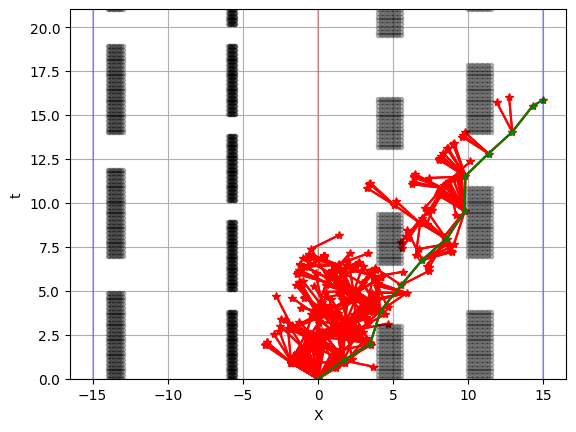

In [ ]:
fig = plt.figure()
ax = fig.subplots()
# RRTstar
for rrtv in V_RRTstar_ts:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrte in E_RRTstar_ts:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, max(T_RRTstar_ts)+5, 100)
for xobsi in range(len(xobs)):
    xobs_this = xobs[xobsi]
    xspace = np.linspace(xobs_this[0], xobs_this[1], 10)
    for xi in xspace:
        for ti in tspace:
            if not obstacle_check(ti, obs_vec[xobsi]):
                plt.plot(xi, ti, 'k.', alpha=0.25)

# Path
for pathi in path_RRTstar_ts:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRTstar_ts)-1):
    plt.plot([path_RRTstar_ts[pathi][0], path_RRTstar_ts[pathi+1][0]], [path_RRTstar_ts[pathi][1], path_RRTstar_ts[pathi+1][1]], '-g')


# Initial/Final
plt.plot([x0, x0], [0, max(T_RRTstar_ts)+5], 'r-', alpha=0.25)
for i in range(len(xf)):
    plt.plot([xf[i], xf[i]], [0, max(T_RRTstar_ts)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf[1]+1)
plt.ylim(0, max(T_RRTstar_ts)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()